**Load Data**

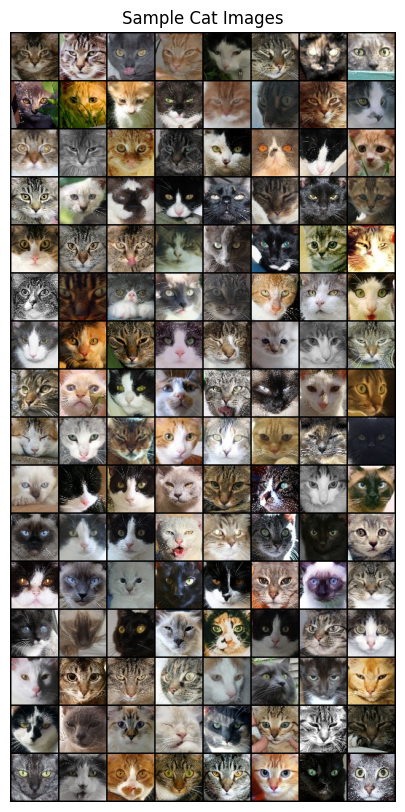

In [8]:
import os
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm

# Settings
data_path = '/kaggle/input/cats-faces-64x64-for-generative-models'
image_size = 32
batch_size = 128
latent_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
lr = 0.0002


# Load and filter only cats (class 0)
train_ds = ImageFolder(data_path, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))

cat_subset = Subset(train_ds, list(range(10000)))
cat_loader = DataLoader(cat_subset, batch_size=batch_size, shuffle=True, num_workers=3, pin_memory=True)


# Device helpers
def get_default_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Move training data to device
train_dl = DeviceDataLoader(cat_loader, device)

# Denormalization helper
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# Show a batch of real cat images
def show_batch(dl):
    for batch in dl:
        if isinstance(batch, (list, tuple)):
            images = batch[0]  # discard labels if present
        else:
            images = batch
        break
    grid = make_grid(denorm(images), nrow=8)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title('Sample Cat Images')
    plt.show()

# Show images from the cat_loader
show_batch(cat_loader)


Genrator 

In [9]:
# generator = nn.Sequential(
#     nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.BatchNorm2d(512),
#     nn.ReLU(True),
#     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.ReLU(True),
#     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.ReLU(True),
#     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.ReLU(True),
#     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.Tanh()
# )
# generator = to_device(generator, device)
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False), # 1x1 -> 4x4
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False), # 4x4 -> 8x8
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False), # 8x8 -> 16x16
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False), # 16x16 -> 32x32
    nn.Tanh()
)
generator = to_device(generator, device)


In [10]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    loss.backward()
    opt_g.step()
    return loss.item()


Descrmenator

In [11]:
# discriminator = nn.Sequential(
#     nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(64),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(128),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(256),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
#     nn.BatchNorm2d(512),
#     nn.LeakyReLU(0.2, inplace=True),
#     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
#     nn.Flatten(),
#     nn.Sigmoid()
# )
# discriminator = to_device(discriminator, device)

discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),   # 32x32 -> 16x16
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), # 16x16 -> 8x8
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), # 8x8 -> 4x4
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),  # 4x4 -> 1x1
    nn.Flatten(),
    nn.Sigmoid()
)
discriminator = to_device(discriminator, device)


In [12]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), torch.mean(real_preds).item(), torch.mean(fake_preds).item()

Training loop

In [ ]:
torch.cuda.empty_cache()
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
losses_g, losses_d, real_scores, fake_scores = [], [], [], []
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
num_batches = len(train_dl)
epochs=1000
for epoch in tqdm(range(epochs)):
    total_loss_d =0
    total_loss_g= 0
    total_real_score= 0
    total_fake_score =0
    for real_images, _ in train_dl:
        loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)
        total_loss_d += loss_d
        total_loss_g += loss_g
        total_real_score += real_score
        total_fake_score += fake_score
    avg_loss_d = total_loss_d / num_batches
    avg_loss_g = total_loss_g / num_batches
    losses_g.append(avg_loss_g)
    losses_d.append(avg_loss_d)

    avg_real_score = total_real_score / num_batches
    avg_fake_score = total_fake_score / num_batches
    # save_samples(epoch + 1, fixed_latent)
    # print(f"Epoch [{epoch+1}/{epochs}], Loss G: {avg_loss_g:.4f}, Loss D: {avg_loss_d:.4f}, Real: {avg_real_score:.4f}, Fake: {avg_fake_score:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # plt.figure(figsize=(10, 5))
        # plt.plot(losses_g, label='Generator Loss')
        # plt.plot(losses_d, label='Discriminator Loss')
        # plt.legend()
        # plt.xticks(range(0, epoch, 5))
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title('Loss vs. epochs')
        # plt.show()
        torch.save(generator.state_dict(), f"project_g.pkl")
        torch.save(discriminator.state_dict(), f"project_d.pkl")
        

plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.xticks(range(0, epoch, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. epochs')
plt.show()




In [ ]:
def reproduce():
    model_path="project_g.pkl"
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    # torch.cuda.manual_seed(42)
    # Generate images
    fixed_latent = torch.randn(32, latent_size, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(fixed_latent)

    # Save the generated images
    save_image(denorm(fake_images), "reproduced_images.png", nrow=8)
    #Plot the images
    plt.figure(figsize=(10, 20))
    plt.axis("off")
    plt.imshow(make_grid(denorm(fake_images).cpu(), nrow=8).permute(1, 2, 0)) 
    plt.show()
reproduce()


In [8]:

import torch
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as tt

# Transform: resize, crop, normalize to [-1, 1]
transform = tt.Compose([
    tt.Resize(64),
    tt.CenterCrop(64),
    tt.ToTensor(),
    tt.Normalize([0.5]*3, [0.5]*3)
])

# Load full CelebA dataset (TorchVision will download it if not present)
celeba_full = CelebA(root='./data', split='train', download=True, transform=transform)

# Take a subset 
subset_size = 5000
indices = list(range(subset_size))
celeba_subset = Subset(celeba_full, indices)

# DataLoader with the subset
celeba_loader = DataLoader(celeba_subset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)


In [9]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)
train_dl=DeviceDataLoader(celeba_loader, device)

100%|██████████| 150/150 [10:59<00:00,  4.40s/it]


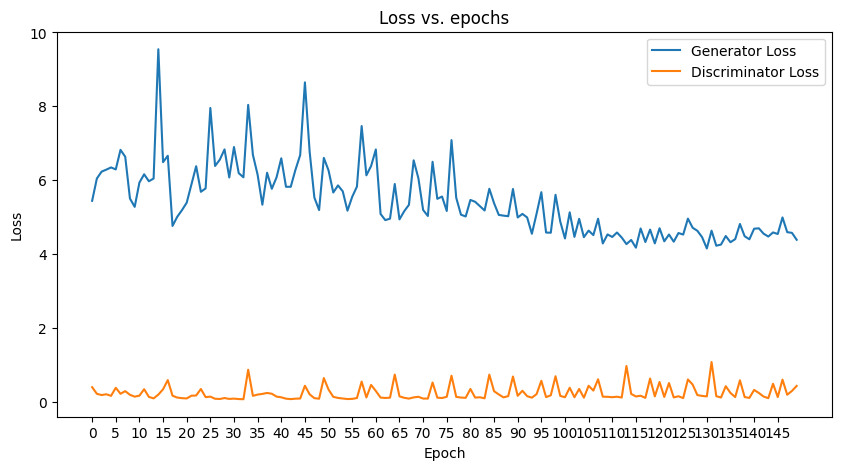

In [10]:
torch.cuda.empty_cache()
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
losses_g, losses_d, real_scores, fake_scores = [], [], [], []
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
num_batches = len(train_dl)
epochs=150
for epoch in tqdm(range(epochs)):
    total_loss_d =0
    total_loss_g= 0
    total_real_score= 0
    total_fake_score =0
    for real_images, _ in train_dl:
        loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
        loss_g = train_generator(opt_g)
        total_loss_d += loss_d
        total_loss_g += loss_g
        total_real_score += real_score
        total_fake_score += fake_score
    avg_loss_d = total_loss_d / num_batches
    avg_loss_g = total_loss_g / num_batches
    losses_g.append(avg_loss_g)
    losses_d.append(avg_loss_d)

    avg_real_score = total_real_score / num_batches
    avg_fake_score = total_fake_score / num_batches
    # save_samples(epoch + 1, fixed_latent)
    # print(f"Epoch [{epoch+1}/{epochs}], Loss G: {avg_loss_g:.4f}, Loss D: {avg_loss_d:.4f}, Real: {avg_real_score:.4f}, Fake: {avg_fake_score:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # plt.figure(figsize=(10, 5))
        # plt.plot(losses_g, label='Generator Loss')
        # plt.plot(losses_d, label='Discriminator Loss')
        # plt.legend()
        # plt.xticks(range(0, epoch, 5))
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title('Loss vs. epochs')
        # plt.show()
        torch.save(generator.state_dict(), f"project_g_face.pkl")
        torch.save(discriminator.state_dict(), f"project_d.pkl")
        

plt.figure(figsize=(10, 5))
plt.plot(losses_g, label='Generator Loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.xticks(range(0, epoch, 5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. epochs')
plt.show()




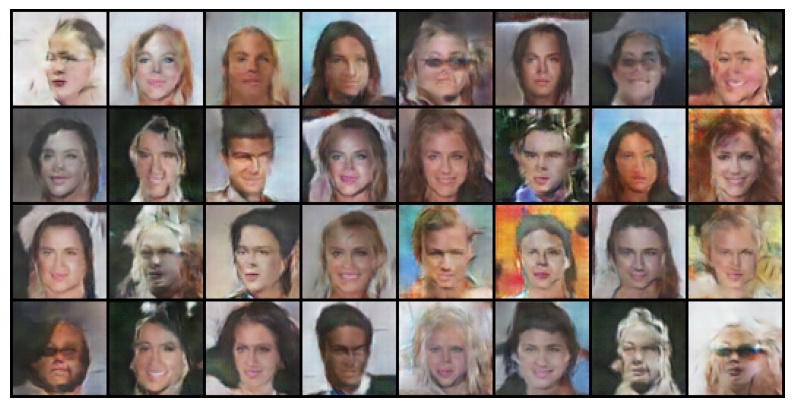

In [11]:
def reproduce():
    model_path="project_g_face.pkl"
    generator.load_state_dict(torch.load(model_path, map_location=device))
    generator.eval()
    # torch.cuda.manual_seed(42)
    # Generate images
    fixed_latent = torch.randn(32, latent_size, 1, 1, device=device)
    with torch.no_grad():
        fake_images = generator(fixed_latent)

    # Save the generated images
    save_image(denorm(fake_images), "reproduced_images.png", nrow=8)
    #Plot the images
    plt.figure(figsize=(10, 20))
    plt.axis("off")
    plt.imshow(make_grid(denorm(fake_images).cpu(), nrow=8).permute(1, 2, 0)) 
    plt.show()
reproduce()
